<a href="https://colab.research.google.com/github/JuliethQP/modelos_ia_prueba/blob/master/Analisis_descriptivo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Cargar los datos**

In [3]:
import pandas as pd

df = pd.read_csv("/content/brain_conditions_detailed_dataset.csv", sep=';')

df.head()

,Case ID,Condition,Age,Sex,Clinical Note,Treatment
0,brain_glioma_0001,Brain Glioma,74,F,Patient is experiencing memory lapses and spee...,surgery
1,brain_glioma_0002,Brain Glioma,66,F,Patient is experiencing visual disturbances an...,chemotherapy
2,brain_glioma_0003,Brain Glioma,62,F,Patient is experiencing memory lapses and dizz...,surgery
3,brain_glioma_0004,Brain Glioma,24,M,Patient is experiencing memory lapses and pers...,surgery
4,brain_glioma_0005,Brain Glioma,69,M,Patient is experiencing dizziness and frequent...,surgery


**Limpieza de datos**

In [4]:
# Verificar columnas y valores faltantes
print("Valores nulos por columna:")
print(df.isnull().sum())

# Eliminar filas con valores nulos (si es necesario)
df = df.dropna()


print("\nTipos de datos:")
print(df.dtypes)


Valores nulos por columna:
Case ID          44
Condition         0
Age               0
Sex               0
Clinical Note     0
Treatment         0
dtype: int64

Tipos de datos:
Case ID          object
Condition        object
Age               int64
Sex              object
Clinical Note    object
Treatment        object
dtype: object


Se considera que al tener 44 case id en nulo, podemos tomar la decisiòn de eliminar o no, dependiendo de el modelo, si un modelo que va a evaluar la la nota clinica para determinar el tratamiento, posiblemente no sea necesario eliminar, pero si es un modelo que combina las imagenes, ya que case id nos indica la imagen màs la nota clinica para determinar el tipo de tumor y el tratamiento, si es necesario hacer la eliminación.

In [5]:
# Eliminar filas donde Case ID sea nulo
df = df.dropna(subset=['Case ID'])


print(df.isnull().sum())

Case ID          0
Condition        0
Age              0
Sex              0
Clinical Note    0
Treatment        0
dtype: int64


**Análisis descriptivo**

               Age
count  6012.000000
mean     51.770459
std      19.627182
min      18.000000
25%      35.000000
50%      52.000000
75%      69.000000
max      85.000000


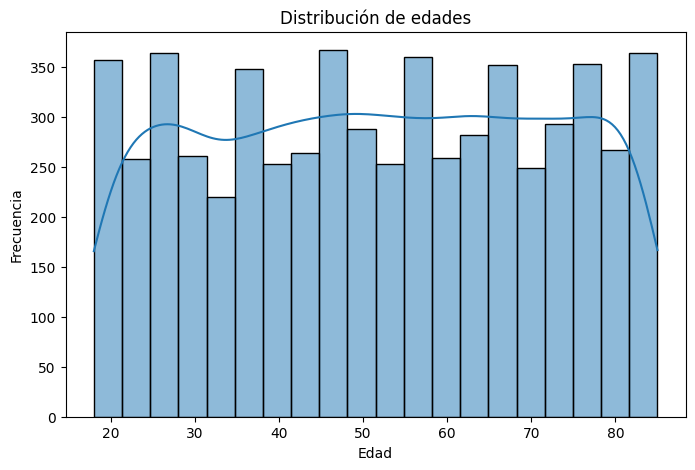

In [6]:
print(df.describe())

# Distribución de edades
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(df['Age'], kde=True, bins=20)
plt.title("Distribución de edades")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
plt.show()

Con lo anterior, se tiene una cantidad de pacientes de 6012, la edad minima es 18, la edad maxima es 85. La edad promedio de los pacientes es de aproximadamente 51.77 años, con una desviación estándar de 19.63 años, lo que indica una variabilidad moderada en las edades. La mediana es de 52 años, lo que sugiere que la mitad de los pacientes tiene una edad igual o menor a ese valor. Además, el rango intercuartílico (IQR) muestra que el 50% central de la población se encuentra entre los 35 y 69 años,  lo que refuerza la presencia de una distribución equilibrada de adultos jóvenes, adultos mayores y personas de edad avanzada dentro del conjunto analizado

**Distribución de clases (Condition y Treatment)**

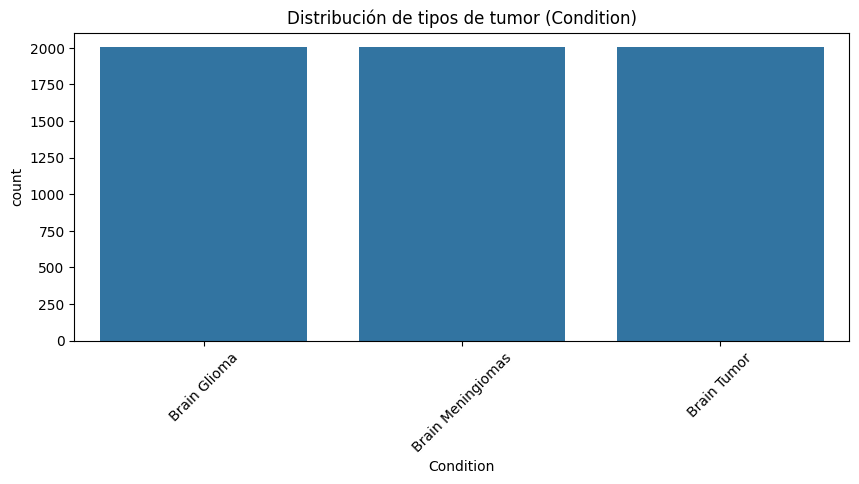

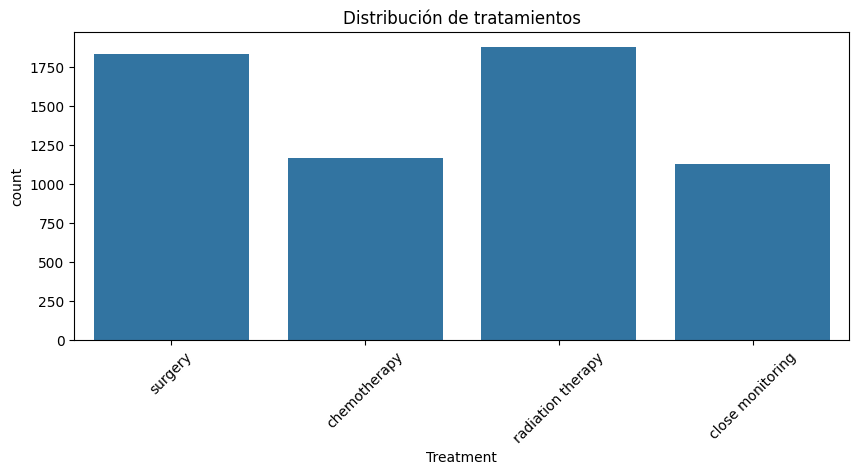

In [7]:
plt.figure(figsize=(10,4))
sns.countplot(data=df, x='Condition')
plt.title("Distribución de tipos de tumor (Condition)")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,4))
sns.countplot(data=df, x='Treatment')
plt.title("Distribución de tratamientos")
plt.xticks(rotation=45)
plt.show()

El conjunto de datos presenta una distribución equilibrada entre las tres clases de tumores cerebrales identificadas: Brain Glioma, Brain Meningiomas y Brain Tumor (genérico). Cada una de estas condiciones aparece aproximadamente 2.000 veces, lo que representa un equilibrio muy positivo para tareas de clasificación; reduciendo el riesgo de sesgo del modelo hacia una clase dominante

En contraste, la quimioterapia y el monitoreo cercano presentan frecuencias menores, con cerca de 1.150 y 1.100 casos, respectivamente. Esta distribución indica que el dataset está algo desequilibrado en la variable Treatment, lo cual puede influir en el comportamiento del modelo de clasificación si no se aplican estrategias

**Proporción de sexos**

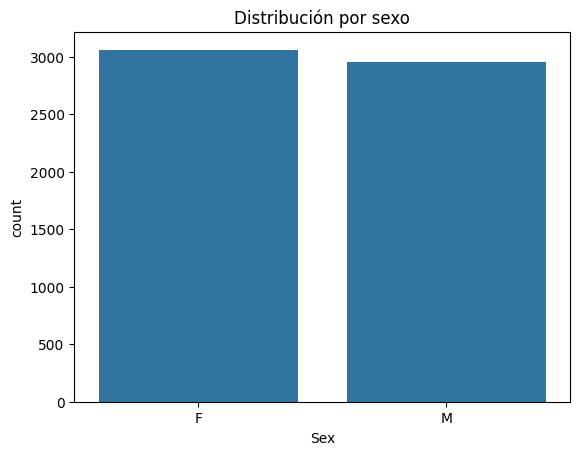

In [8]:
sns.countplot(data=df, x='Sex')
plt.title("Distribución por sexo")
plt.show()

La variable Sex presenta una distribución equilibrada entre mujeres (F) y hombres (M). En términos absolutos, hay una ligera mayoría de pacientes mujeres, con poco más de 3.000 casos, frente a aproximadamente 2.950 hombres. Esta diferencia es mínima y no representa un desbalance crítico en los datos, lo cual es positivo para el entrenamiento del modelo, ya que no favorece ni penaliza el aprendizaje hacia un sexo específico.

**Prueba de hipótesis – ¿La edad difiere por tratamiento? (t-test)**

In [9]:
from scipy.stats import ttest_ind

grupo1 = df[df['Treatment'] == 'surgery']['Age']
grupo2 = df[df['Treatment'] == 'chemotherapy']['Age']

t_stat, p_value = ttest_ind(grupo1, grupo2)
print("t-statistic:", t_stat)
print("p-value:", p_value)

if p_value < 0.05:
    print("Diferencia significativa entre edades de tratamiento.")
else:
    print("No hay diferencia significativa entre edades.")


t-statistic: 0.3380857635523019
p-value: 0.7353222149683942
No hay diferencia significativa entre edades.


***Prueba de hipótesis – ¿Hay relación entre sexo y tipo de tumor? ***

In [10]:
from scipy.stats import chi2_contingency


tabla = pd.crosstab(df['Sex'], df['Condition'])


chi2, p, dof, expected = chi2_contingency(tabla)

print("Chi-cuadrado:", chi2)
print("p-value:", p)

if p < 0.05:
    print("Existe una relación significativa entre sexo y tipo de tumor.")
else:
    print("No hay relación significativa entre sexo y tipo de tumor.")


Chi-cuadrado: 0.7201174065480698
p-value: 0.6976353713885728
No hay relación significativa entre sexo y tipo de tumor.


**Análisis de frecuencia de palabras por tratamiento**

In [11]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import string

stop_words = set(stopwords.words('english'))

def limpiar_texto(texto):
    texto = texto.lower().translate(str.maketrans('', '', string.punctuation))
    palabras = texto.split()
    return [word for word in palabras if word not in stop_words]

# Agrupar notas por tratamiento
tratamientos = df['Treatment'].unique()

for t in tratamientos:
    notas = df[df['Treatment'] == t]['Clinical Note'].dropna().apply(limpiar_texto)
    todas = sum(notas.tolist(), [])
    frec = Counter(todas).most_common(10)
    print(f"\nPalabras más comunes para {t}:")
    for palabra, cuenta in frec:
        print(f"{palabra}: {cuenta}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



Palabras más comunes para surgery:
patient: 1836
experiencing: 1836
symptoms: 1836
described: 1836
nature: 1836
months: 832
past: 635
weeks: 603
speech: 568
headaches: 414

Palabras más comunes para chemotherapy:
patient: 1166
experiencing: 1166
symptoms: 1166
described: 1166
nature: 1166
months: 600
last: 412
weeks: 412
past: 378
seizures: 318

Palabras más comunes para radiation therapy:
patient: 1881
experiencing: 1881
symptoms: 1881
described: 1881
nature: 1881
months: 840
weeks: 632
past: 622
speech: 586
headaches: 420

Palabras más comunes para close monitoring:
patient: 1129
experiencing: 1129
symptoms: 1129
described: 1129
nature: 1129
past: 388
speech: 386
months: 370
problems: 369
weeks: 353


En todos los tratamientos, las palabras más comunes fueron “patient”, “experiencing”, “symptoms”, “described” y “nature”, lo cual refleja un lenguaje clínico estándar y neutro utilizado para describir los casos. Sin embargo, al observar los siguientes términos más frecuentes, se encontraron diferencias sutiles que podrían estar relacionadas con la gravedad o características del cuadro clínico.

En los tratamientos más invasivos, como cirugía y radioterapia, aparecen términos como “speech”, “headaches” y “weeks” con alta frecuencia, lo que sugiere síntomas neurológicos progresivos que pueden justificar una intervención directa. En cambio, en los casos asignados a quimioterapia, se observó una alta aparición de la palabra “seizures”, lo que puede indicar un patrón sintomático diferente, posiblemente asociado a tumores más infiltrativos o sistémicos. Por su parte, en pacientes bajo monitoreo cercano, el término “problems” aparece entre las más comunes, lo que podría indicar una condición más estable o menos definida, sin una intervención inmediata.

**Análisis entre tipo de cáncer la nota clínica y el tratamiento **

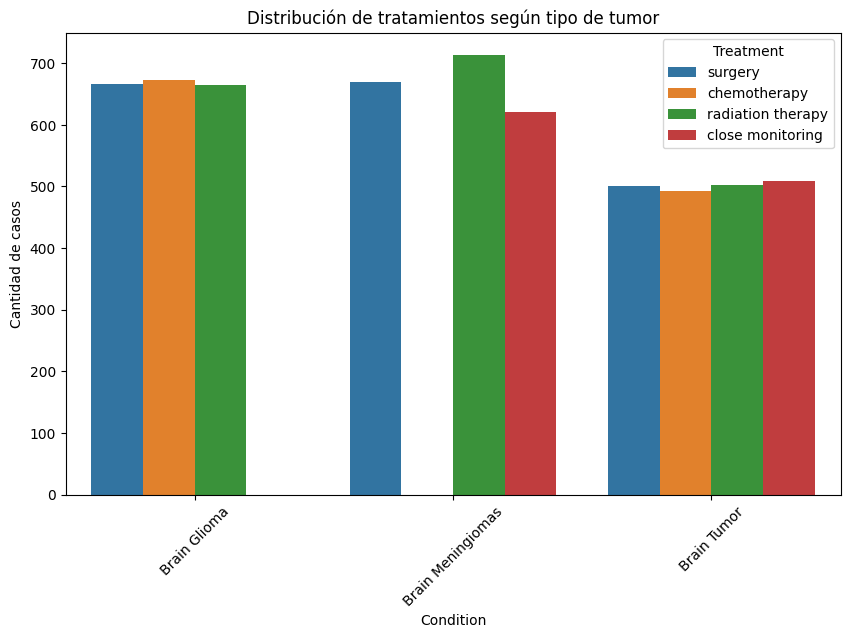

In [12]:
# Distribución de tratamientos por tipo de cáncer
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(x='Condition', hue='Treatment', data=df)
plt.title("Distribución de tratamientos según tipo de tumor")
plt.xticks(rotation=45)
plt.ylabel("Cantidad de casos")
plt.show()

En el caso de los gliomas cerebrales (Brain Glioma), se observa una distribución bastante uniforme entre los tres tratamientos principales: cirugía, quimioterapia y radioterapia.

Por otro lado, en los meningiomas cerebrales (Brain Meningiomas) se presenta una predominancia clara de la radioterapia, seguida por la cirugía y el monitoreo cercano

Finalmente, en la categoría genérica de Brain Tumor, que posiblemente agrupa casos sin una clasificación más específica, la distribución es más balanceada entre los cuatro tratamientos, sin una estrategia claramente dominante

**Palabras frecuentes por combinación Condition + Treatment**

In [14]:
from collections import Counter
import string
import nltk
from nltk.corpus import stopwords


nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def limpiar_texto(texto):
    texto = texto.lower().translate(str.maketrans('', '', string.punctuation))
    palabras = texto.split()
    return [word for word in palabras if word not in stop_words]


condicion = 'Brain Glioma'
tratamiento = 'surgery'


notas_filtradas = df[(df['Condition'] == condicion) & (df['Treatment'] == tratamiento)]['Clinical Note'].dropna()


palabras_limpias = notas_filtradas.apply(limpiar_texto)
todas_las_palabras = sum(palabras_limpias.tolist(), [])


frecuencias = Counter(todas_las_palabras).most_common(15)


print(f"Palabras más comunes para {condicion} + {tratamiento}:\n")
for palabra, cantidad in frecuencias:
    print(f"{palabra}: {cantidad}")



Palabras más comunes para Brain Glioma + surgery:

patient: 666
experiencing: 666
symptoms: 666
described: 666
nature: 666
months: 438
past: 232
2: 232
last: 228
weeks: 228
memory: 211
lapses: 211
6: 206
dizziness: 201
speech: 192


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


En las notas clínicas de pacientes con Brain Glioma tratados con cirugía, se observa que palabras como "memory", "lapses", "dizziness" y "speech" aparecen con alta frecuencia. Estas palabras hacen referencia a síntomas neurológicos clave que podrían estar directamente relacionados con la decisión de realizar una intervención quirúrgica